In [1]:
# Run python sript if enter_parameters is needed.
# Run ipython or notebook with enter_parameters disabled if cell outputs need to be saved.
run_from_ipython = 'get_ipython' in globals()
# Use ipython display when running notebook. Print directly to console when running sript.
display = display if run_from_ipython else print

In [2]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from utils import *
from process import *
from analysis import *
from plots import *

if run_from_ipython:
    %matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [3]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(config['cache_dir'], "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# Whether to manually enter parameters for analysis
enter_parameters = config['enter_parameters']
whether_redo = redo_condition(enter_parameters)

## Get session and probe

In [4]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']
session = cache.get_session_data(session_id)

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [5]:
output_dir = config['output_dir']
session_dir = os.path.join(output_dir, f'session_{session_id:d}')
info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
with open(info_file) as f:
    info = json.load(f)
print(json.dumps(info, indent=4))

probe_id = info['probe_id']
probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
parameters_dict = info['parameters']
fig_disp = figure_display_function(config)

{
    "session_id": 766640955,
    "ecephys_structure_acronym": "VISp",
    "probe_id": 773592320,
    "center_channel_id": 850025390,
    "center_unit_channel_id": 850025390,
    "fs": 1249.99984068252,
    "parameters": {
        "drifting_gratings_75_repeats_knee": true,
        "drifting_gratings_contrast_knee": true,
        "natural_movie_one_more_repeats_knee": true,
        "scaleogram_channels": 4,
        "natural_movie_one_shuffled_knee": true,
        "power_freq_band": [
            20.0,
            40.0
        ],
        "drifting_gratings_knee": true,
        "fr_smooth_sigma": 0.02,
        "fr_normalization_scale": "range",
        "fr_normalize_quantile": 0.2
    },
    "has_ccf": true,
    "unit_has_ccf": true,
    "channel_group_by_ccf": true,
    "n_channel_groups": 10,
    "movies_pop_parameters": {
        "fr_smooth_sigma": 0.02,
        "fr_normalization_scale": "range",
        "fr_normalize_quantile": 0.2,
        "extend_time": 0.5,
        "beta_band": [


## Load LFP channels

In [6]:
filepath = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_lfp_channel_groups.nc')
with xr.open_dataset(filepath) as f:
    lfp_array = f.load()
lfp_array = lfp_array.assign_attrs(fs=info['fs']).rename(group_id='channel')
display(lfp_array)

<xarray.Dataset>
Dimensions:  (time: 12254090, channel: 10)
Coordinates:
  * time     (time) float64 3.756 3.757 3.758 ... 9.807e+03 9.807e+03 9.807e+03
  * channel  (channel) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    LFP      (channel, time) float32 1.04e-06 4.94e-06 ... 0.0001544 0.0001201
Attributes:
    fs:       1249.99984068252

In [7]:
channel_group_map = pd.read_csv(filepath.replace('.nc', '.csv'), index_col='id')
group_dv_ccf = dict(zip(channel_group_map['group_id'], channel_group_map['dorsal_ventral_ccf_coordinate']))
display(channel_group_map)

,group_id,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,
850025412,3,8464.555556,933.777778,8193.555556
850025314,9,8313.000000,1404.000000,8044.428571
850025316,9,8313.000000,1404.000000,8044.428571
850025318,9,8313.000000,1404.000000,8044.428571
850025320,9,8313.000000,1404.000000,8044.428571
...,...,...,...,...
850025478,0,8565.555556,612.222222,8256.888889
850025480,0,8565.555556,612.222222,8256.888889
850025482,0,8565.555556,612.222222,8256.888889


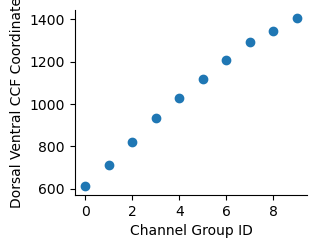

In [8]:
plt.figure(figsize=(3, 2.4))
plt.plot(group_dv_ccf.keys(), group_dv_ccf.values(), marker='o', linestyle='none')
plt.xlabel('Channel Group ID')
plt.ylabel('Dorsal Ventral CCF Coordinate')
fig_disp('channel_group_coordinates')

## Analysis

In [9]:
session_type = session.session_type

if session_type == 'brain_observatory_1.1':
    stimulus_name_dict = {
        'drifting_gratings': ['drifting_gratings'],
        'natural_movies': ['natural_movie_one', 'natural_movie_three'],
        'static_gratings': ['static_gratings'],
        'natural_scenes': ['natural_scenes'],
    }
elif session_type == 'functional_connectivity':
    stimulus_name_dict = {
        'drifting_gratings': ['drifting_gratings_75_repeats', 'drifting_gratings_contrast'],
        'natural_movies': ['natural_movie_one_more_repeats', 'natural_movie_one_shuffled'],
        'static_gratings': [],
        'natural_scenes': [],
    }

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [12]:
stimulus_presentations = session.stimulus_presentations
channel_id = info['center_unit_channel_id']
group_id = channel_group_map.loc[channel_id, 'group_id']

print(f"Channel group: {group_id:d}")

psd_tseg = 1.0
psd_avg_das = {}

savefig = True
plt_range = (0, 100.)
sxx_plt_range = [2.0, 80.0]

Channel group: 4


### drifting_gratings

In [32]:
lfp_array

<xarray.Dataset>
Dimensions:  (time: 12254090, channel: 10)
Coordinates:
  * time     (time) float64 3.756 3.757 3.758 ... 9.807e+03 9.807e+03 9.807e+03
  * channel  (channel) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    LFP      (channel, time) float32 1.04e-06 4.94e-06 ... 0.0001544 0.0001201
Attributes:
    fs:       1249.99984068252


drifting_gratings_75_repeats
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -6.1569, 683.1736, 2.6408                                     
                                                                                                  
                                       1 peaks were found:       

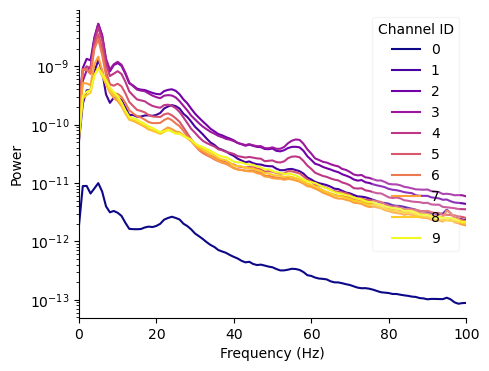

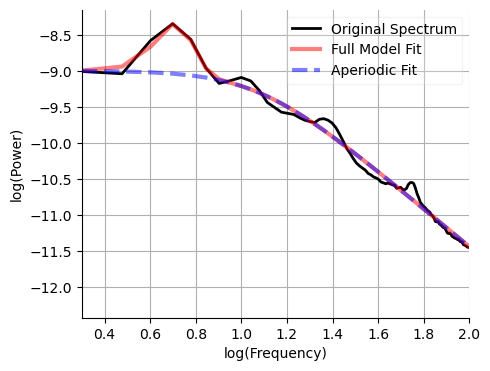

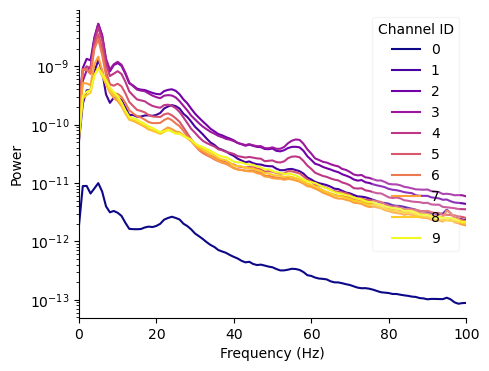

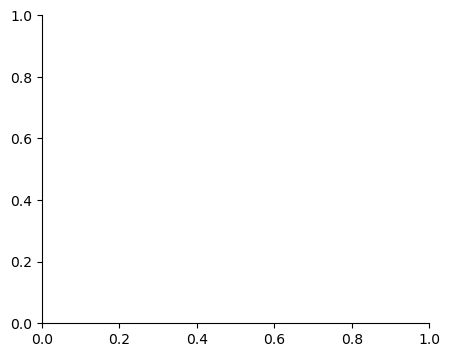

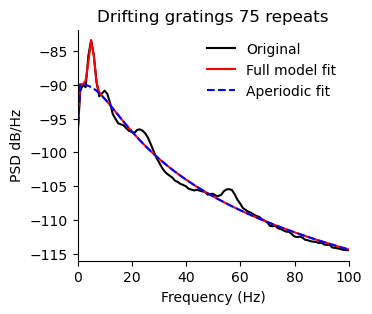


drifting_gratings_contrast
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.4900, 68.3776, 2.5397                                     
                                                                                                  
                                       1 peaks were found:         

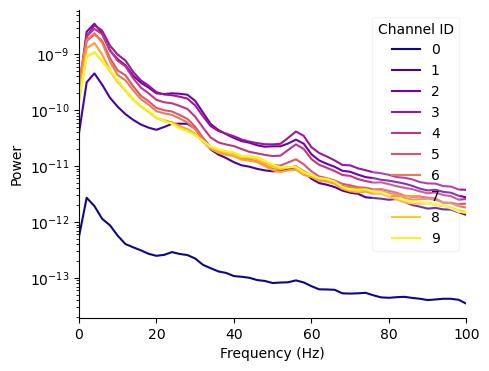

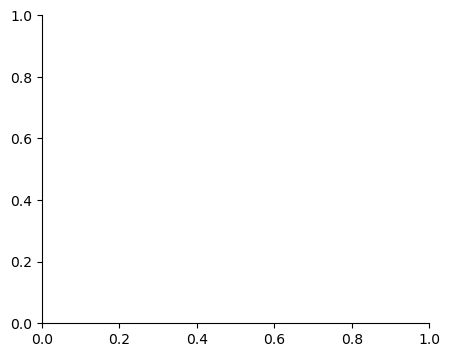

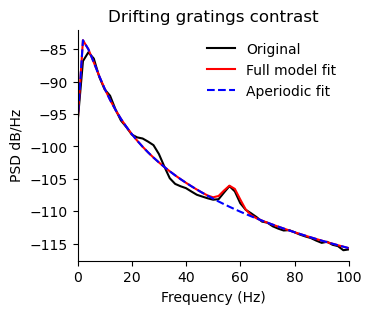

In [13]:
drifting_gratings_psd = {}
align_gratings_results = {}
for stim in stimulus_name_dict['drifting_gratings']:
    print(f'\n{stim}')
    redo = True
    while redo:
        ap_knee, = get_parameters({stim + '_knee': True}, parameters_dict, enter_parameters)
        aperiodic_mode = 'knee' if ap_knee else 'fixed'

        drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
            stimulus_presentations, stimulus_name=stim)
        align_gratings_results[stim] = drifting_gratings_presentations, grating_ids, grating_times, grating_duration
        aligned_lfp = align_trials(lfp_array, grating_ids, grating_times, window=(0., grating_duration))
        drifting_gratings_psd[stim] = trial_psd(aligned_lfp, tseg=psd_tseg)
        psd_avg = drifting_gratings_psd[stim].mean(dim='presentation_id')
        fooof_result, fig1, _ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=plt_range, figsize=(5, 4),
                                                 aperiodic_mode=aperiodic_mode, dB_threshold=3., max_n_peaks=10, plot=not savefig, plt_log=True)

        psd_avg_das[stim] = psd_avg
        if savefig:
            fig2, ax = plt.subplots(figsize=(3.5, 3))
            psd_avg_plt = psd_avg.sel(channel=group_id, frequency=slice(*plt_range))
            _ = plot_fooof(psd_avg_plt.frequency.values, psd_avg_plt.values, fooof_result[0], plt_log=False, plt_range=plt_range, plt_db=True, ax=ax)
            ax.set_title(stim.replace('_', ' ').capitalize())
        fig_disp({stim + '_psd': fig1, f'{stim:s}_fooof_channel_{group_id}': fig2})

        redo = whether_redo()

### static_gratings

In [14]:
for stim in stimulus_name_dict['static_gratings']:
    print(f'\n{stim}')
    redo = True
    while redo:
        ap_knee, = get_parameters({stim + '_knee': False}, parameters_dict, enter_parameters)
        aperiodic_mode = 'knee' if ap_knee else 'fixed'

        _, presentations_ids, presentations_times, trial_duration = align_gratings(stimulus_presentations, stimulus_name=stim)
        aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0., trial_duration))
        psd_avg = trial_psd(aligned_lfp, tseg=psd_tseg).mean(dim='presentation_id')

        psd_avg_das[stim] = psd_avg
        _, fig1, fig2 = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=plt_range, figsize=(5, 4),
                                         aperiodic_mode=aperiodic_mode, dB_threshold=3., max_n_peaks=10, plt_log=True)
        fig_disp({stim + '_psd': fig1, f'{stim:s}_fooof_channel_{group_id}': fig2})

        redo = whether_redo()

    # # Scaleogram
    # redo = True
    # while redo:
    #     channel_ids, = get_parameters({'scaleogram_channels': list(map(int, lfp_array.channel))}, parameters_dict, enter_parameters)

    #     aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(-0.05, trial_duration + 0.05))

    #     sxx_avg = trial_averaged_spectrogram(aligned_lfp, tseg=.25)
    #     _ = plot_channel_spectrogram(sxx_avg, channel_id=channel_ids, plt_range=sxx_plt_range, log_power=True,
    #                                 clr_freq_range=None, figsize=(6, 3.6),
    #                                 remove_aperiodic={'freq_range': 200., 'aperiodic_mode': aperiodic_mode})
    #     fig_disp(stim + '_scaleogram')

    #     redo = whether_redo()

### natural_scenes

In [15]:
for stim in stimulus_name_dict['natural_scenes']:
    print(f'\n{stim}')
    redo = True
    while redo:
        ap_knee, = get_parameters({stim + '_knee': False}, parameters_dict, enter_parameters)
        aperiodic_mode = 'knee' if ap_knee else 'fixed'

        _, presentations_ids, presentations_times, trial_duration = align_scenes(stimulus_presentations, stimulus_name=stim)
        aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0., trial_duration))
        psd_avg = trial_psd(aligned_lfp, tseg=psd_tseg).mean(dim='presentation_id')

        psd_avg_das[stim] = psd_avg
        _, fig1, fig2 = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=plt_range, figsize=(5, 4),
                                         aperiodic_mode=aperiodic_mode, dB_threshold=3., max_n_peaks=10, plt_log=True)
        fig_disp({stim + '_psd': fig1, f'{stim:s}_fooof_channel_{group_id}': fig2})

        redo = whether_redo()

    # # Scaleogram
    # redo = True
    # while redo:
    #     channel_ids, = get_parameters({'scaleogram_channels': list(map(int, lfp_array.channel))}, parameters_dict, enter_parameters)

    #     aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(-0.05, trial_duration + 0.05))

    #     sxx_avg = trial_averaged_spectrogram(aligned_lfp, tseg=.25)
    #     _ = plot_channel_spectrogram(sxx_avg, channel_id=channel_ids, plt_range=sxx_plt_range, log_power=True,
    #                                 clr_freq_range=None, figsize=(6, 3.6),
    #                                 remove_aperiodic={'freq_range': 200., 'aperiodic_mode': aperiodic_mode})
    #     fig_disp(stim + '_scaleogram')

    #     redo = whether_redo()

### natural_movies


natural_movie_one_more_repeats
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.5682, 21.0580, 1.9945                                     
                                                                                                  
                                       1 peaks were found:     

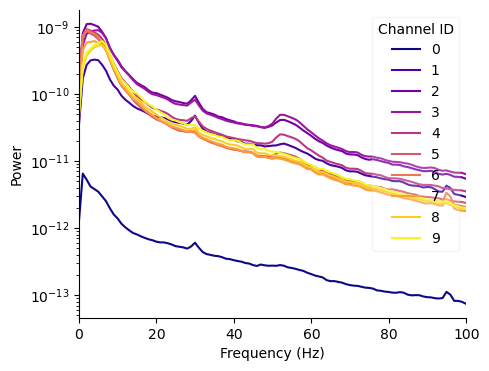

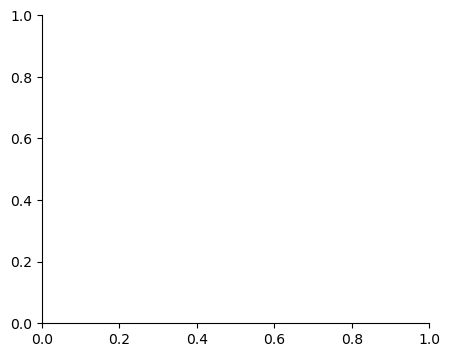

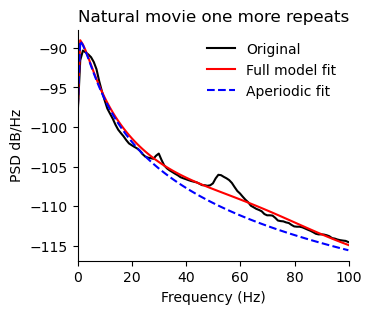


natural_movie_one_shuffled
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.1852, 56.0196, 2.1675                                     
                                                                                                  
                                       1 peaks were found:         

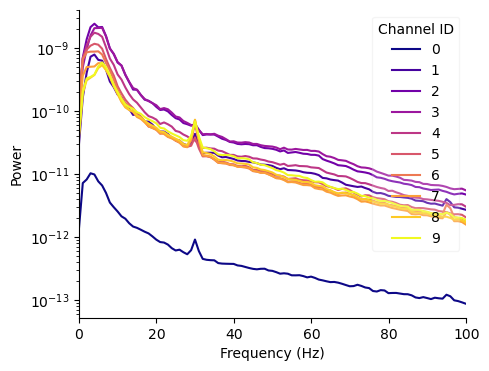

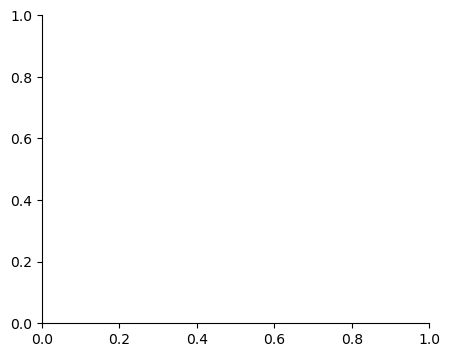

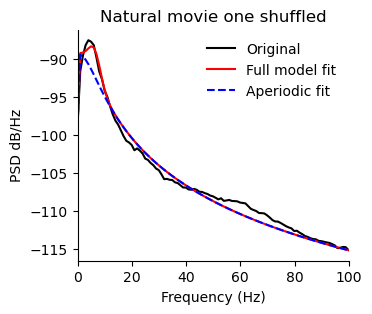

In [16]:
for stim in stimulus_name_dict['natural_movies']:
    print(f'\n{stim}')
    redo = True
    while redo:
        ap_knee, = get_parameters({stim + '_knee': True}, parameters_dict, enter_parameters)
        aperiodic_mode = 'knee' if ap_knee else 'fixed'

        _, presentations_ids, presentations_times, trial_duration = align_movie(stimulus_presentations, stimulus_name=stim)
        aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0., trial_duration))
        psd_avg = trial_psd(aligned_lfp, tseg=psd_tseg).mean(dim='presentation_id')
        fooof_result, fig1, fig2 = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=plt_range, figsize=(5, 4),
                                                    aperiodic_mode=aperiodic_mode, dB_threshold=3., max_n_peaks=10, plot=not savefig, plt_log=True)

        psd_avg_das[stim] = psd_avg
        if savefig:
            fig2, ax = plt.subplots(figsize=(3.5, 3))
            psd_avg_plt = psd_avg.sel(channel=group_id, frequency=slice(*plt_range))
            _ = plot_fooof(psd_avg_plt.frequency.values, psd_avg_plt.values, fooof_result[0], plt_log=False, plt_range=plt_range, plt_db=True, ax=ax)
            ax.set_title(stim.replace('_', ' ').capitalize())
        fig_disp({stim + '_psd': fig1, f'{stim:s}_fooof_channel_{group_id}': fig2})

        redo = whether_redo()

    # # Scaleogram
    # redo = True
    # while redo:
    #     channel_ids, = get_parameters({'scaleogram_channels': group_id}, parameters_dict, enter_parameters)

    #     sxx_avg = trial_averaged_spectrogram(aligned_lfp, tseg=.5)
    #     axs = plot_channel_spectrogram(sxx_avg, channel_id=channel_ids, plt_range=sxx_plt_range, log_power='dB',
    #                                 clr_freq_range=(30., 80.), pad=0.03, figsize=(5, 2.5),
    #                                 remove_aperiodic={'freq_range': 200., 'aperiodic_mode': aperiodic_mode})
    #     if savefig:
    #         axs[0, 0].set_title(stim.replace('_', ' ').capitalize())
    #     fig_disp(stim + '_scaleogram')

    #     redo = whether_redo()

#### Save PSD data

In [17]:
good_pattern = 0 if input('Is the PSD pattern good [y/n]?').lower() == 'n' else 1  # default is good

psd_filepath = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_psd_channel_groups.nc')
for stim, da in psd_avg_das.items():
    # distinguish inconsistent frequency before merging
    psd_avg_das[stim] = da.rename(frequency=f'frequency_{stim:s}')
psd_avg_ds = xr.Dataset(psd_avg_das)
psd_avg_ds = psd_avg_ds.assign_attrs(session_id=session_id, center_unit_group_id=group_id, good_pattern=good_pattern)
# psd_avg_ds.to_netcdf(psd_filepath)

### drifting_gratings conditions

In [18]:
condition_names = ['orientation', 'temporal_frequency', 'contrast']

if session_type == 'brain_observatory_1.1':
    x_cond, y_cond = ('orientation', 'temporal_frequency')
elif session_type == 'functional_connectivity':
    x_cond, y_cond = ('contrast', 'orientation')

cond_label = dict(
    orientation = 'Orientation (deg)',
    temporal_frequency = 'Temporal frequency (Hz)',
    contrast = 'Contrast'
)


drifting_gratings_75_repeats


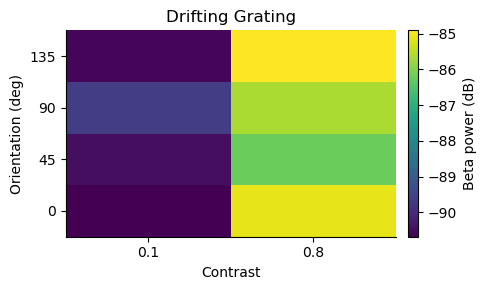


drifting_gratings_contrast


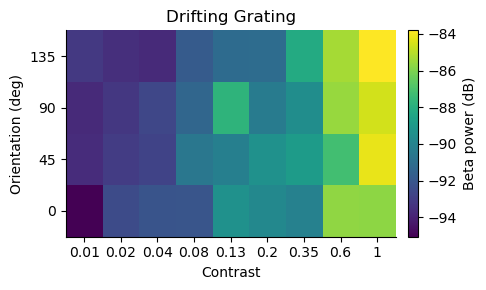

In [19]:
freq_band = (20., 40.)
stimulus_name = stimulus_name_dict['drifting_gratings'][-1]

redo = True
while redo:
    freq_band, = get_parameters({'power_freq_band': freq_band}, parameters_dict, enter_parameters)

    drifting_gratings_cond_psd = {}
    conditions = {}
    for stim in stimulus_name_dict['drifting_gratings']:
        print(f'\n{stim}')
        condition_id, cond_presentation_id = presentation_conditions(
            align_gratings_results[stim][0], condtion_types=condition_names)
        conditions[stim] = condition_id, cond_presentation_id

        cond_psd = [drifting_gratings_psd[stim].sel(presentation_id=i).mean(dim='presentation_id') for i in cond_presentation_id.values()]
        cond_psd = xr.concat(cond_psd, dim=pd.Index(cond_presentation_id, name='condition_id'))
        cond_psd = cond_psd.sel(condition_id=condition_id)
        drifting_gratings_cond_psd[stim] = cond_psd

        cond_band_power = cond_psd.sel(frequency=slice(*freq_band)).integrate('frequency')
        cond_band_power = cond_band_power.sel(channel=[group_id])
        cond_band_power = cond_band_power.mean(dim=set(condition_names) - set([x_cond, y_cond]))

        nchannel = cond_band_power.coords['channel'].size
        _, axs = plt.subplots(nchannel, 1, squeeze=False, figsize=(5, 3 * nchannel))
        for c, ax in zip(cond_band_power.channel, axs.ravel()):
            cpower = cond_band_power.sel(channel=c).transpose(y_cond, x_cond)
            cpower[:] = 10 * np.log10(cpower)
            x = cpower.coords[x_cond].values
            y = cpower.coords[y_cond].values
            cpower = cpower.assign_coords({x_cond: range(x.size), y_cond: range(y.size)})
            cpower.plot.imshow(x=x_cond, y=y_cond, ax=ax, cbar_kwargs=dict(label='Beta power (dB)', pad=0.03))
            ax.set_xticks(cpower.coords[x_cond])
            ax.set_xticklabels(map('{:g}'.format, x))
            ax.set_yticks(cpower.coords[y_cond])
            ax.set_yticklabels(map('{:g}'.format, y))
            ax.set_xlabel(cond_label[x_cond])
            ax.set_ylabel(cond_label[y_cond])
        plt.tight_layout()

        if savefig:
            axs[0, 0].set_title('Drifting Grating')
        fig_disp(f'drifting_grating_power_band_{freq_band[0]:g}-{freq_band[1]:g}')

    redo = whether_redo()


drifting_gratings_75_repeats

Contrast: 0.1
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -6.7772, 137.5208, 2.3814                                     
                                                                                                  
                                       3 peaks wer

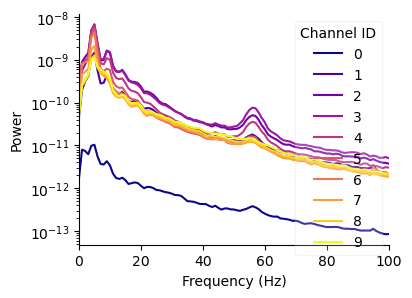

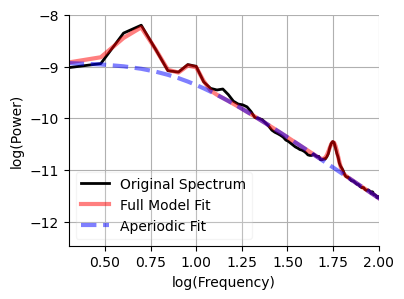


Contrast: 0.8
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -6.0579, 1186.7328, 2.6626                                    
                                                                                                  
                                       2 peaks were found:                      

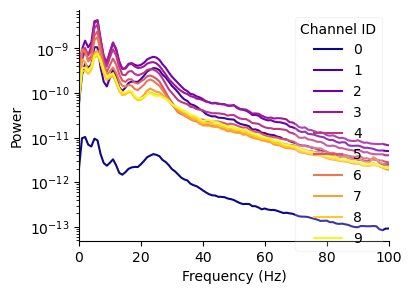

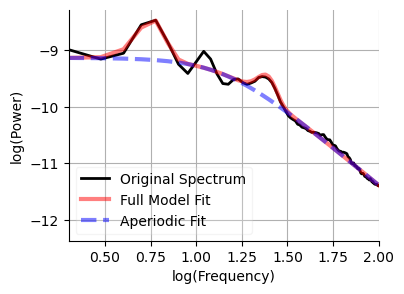


drifting_gratings_contrast

Contrast: 0.01
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.4455, -1.5798, 2.1352                                     
                                                                                                  
                                       1 peaks were

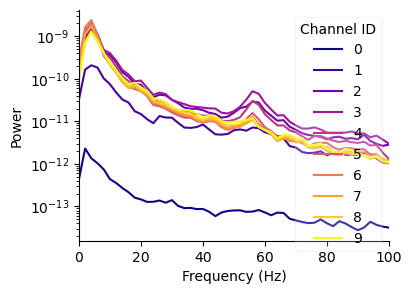

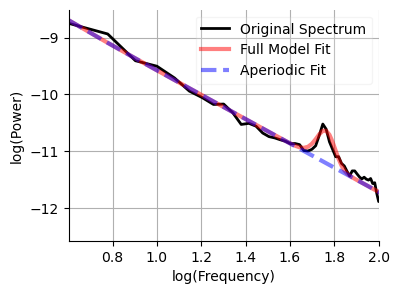


Contrast: 0.02
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.3167, 11.4884, 2.1714                                     
                                                                                                  
                                       1 peaks were found:                     

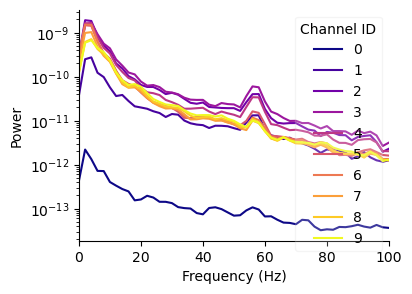

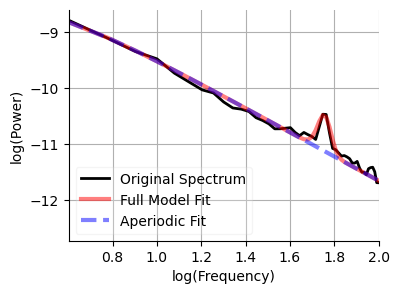


Contrast: 0.04
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0611, -2.5880, 2.3146                                     
                                                                                                  
                                       1 peaks were found:                     

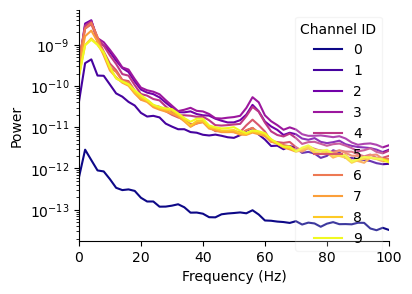

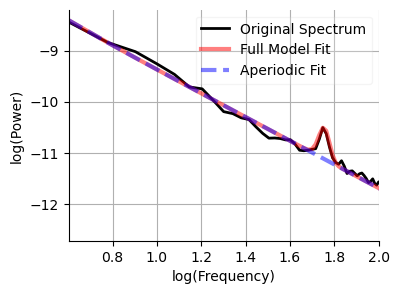


Contrast: 0.08
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.6976, 10.4861, 2.4955                                     
                                                                                                  
                                       1 peaks were found:                     

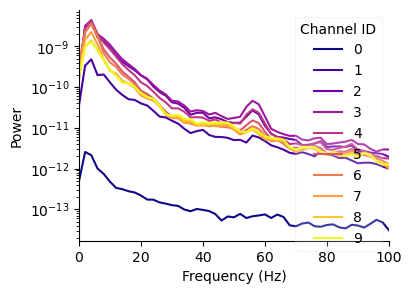

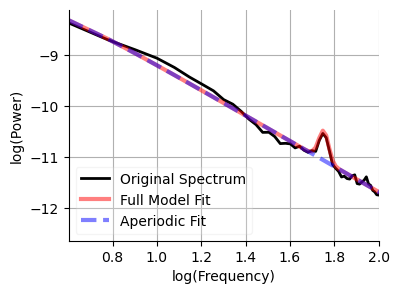


Contrast: 0.13
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.3341, 46.5951, 2.6521                                     
                                                                                                  
                                       1 peaks were found:                     

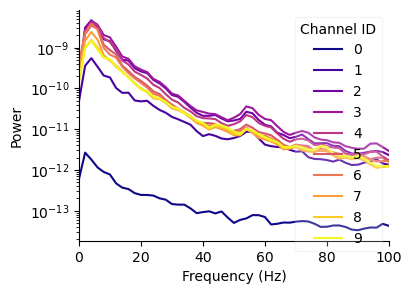

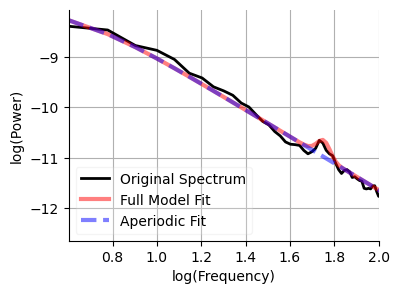


Contrast: 0.2
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7358, 19.6375, 2.4285                                     
                                                                                                  
                                       2 peaks were found:                      

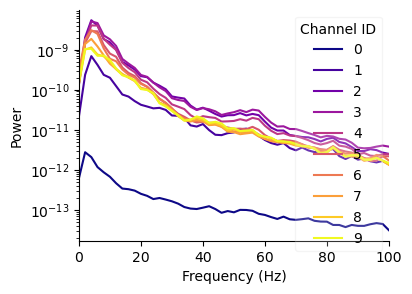

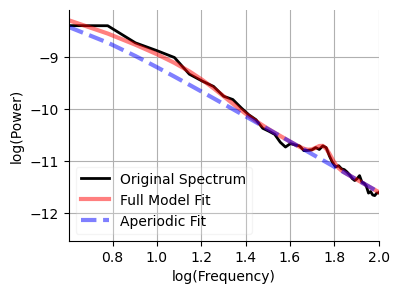


Contrast: 0.35
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.5607, 73.9216, 2.4833                                     
                                                                                                  
                                       1 peaks were found:                     

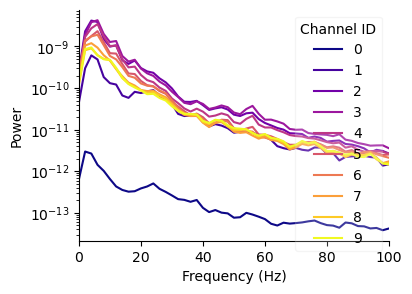

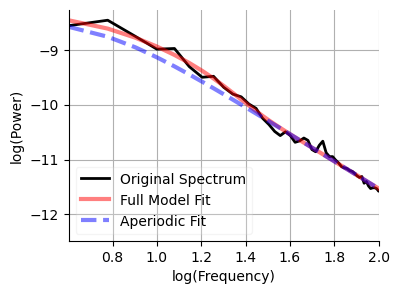


Contrast: 0.6
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -6.3516, 220.2395, 2.5469                                     
                                                                                                  
                                       2 peaks were found:                      

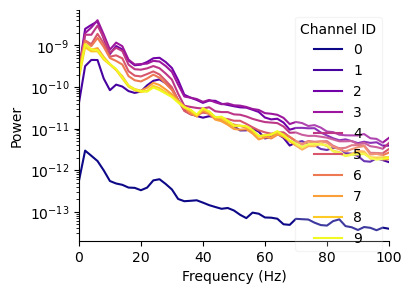

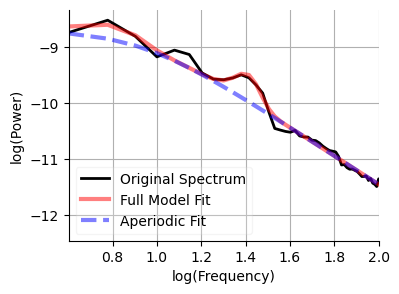


Contrast: 1
Channel ID: 4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -6.4878, 219.3736, 2.4719                                     
                                                                                                  
                                       1 peaks were found:                        

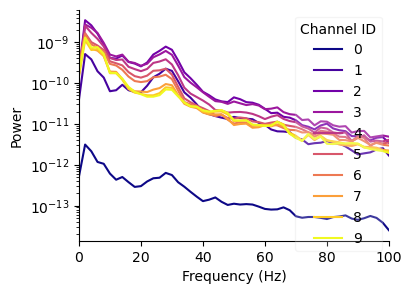

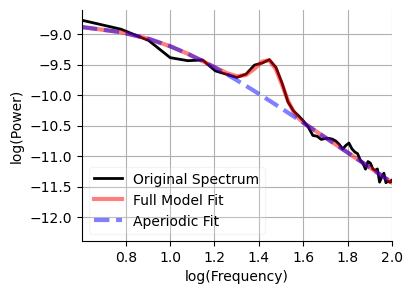

In [20]:
if session_type == 'brain_observatory_1.1':
    avg_except = 'temporal_frequency'
elif session_type == 'functional_connectivity':
    avg_except = 'contrast'

cond_psd_avg = {}

redo = True
while redo:
    ap_knee, = get_parameters({'drifting_gratings_knee': True}, parameters_dict, enter_parameters=False)
    aperiodic_mode = 'knee' if ap_knee else 'fixed'
    for stim in stimulus_name_dict['drifting_gratings']:
        print(f'\n{stim}')
        cond_psd = drifting_gratings_cond_psd[stim]
        psd_avg = cond_psd.mean(dim=set(condition_names) - set([avg_except]))
        cond_psd_avg[stim] = psd_avg

        for cond in cond_psd.coords[avg_except].values:
            print(f'\n{cond_label[avg_except]:s}: {cond:g}')
            _, fig1, fig2 = plot_channel_psd(psd_avg.sel(**{avg_except: cond}), channel_id=group_id,
                                             freq_range=200., plt_range=plt_range, figsize=(4, 3),
                                             aperiodic_mode=aperiodic_mode, dB_threshold=3., max_n_peaks=10, plt_log=True)
            fig_disp({f'drifting_grating_{avg_except:s}_{cond:g}_psd': fig1, f'drifting_grating_{avg_except:s}_{cond:g}_fooof_channel_{group_id}': fig2})

    redo = whether_redo()

In [21]:
cond_psd_filepath = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_drifting_gratings_condition_psd.nc')
cond_psd_avg_ds = {}
for stim, da in cond_psd_avg.items():
    # distinguish inconsistent frequency and conditions before merging
    cond_psd_avg_ds[stim] = da.rename({'frequency': f'frequency_{stim:s}',
                                  avg_except: f'{avg_except:s}_{stim:s}'})
cond_psd_avg_ds = xr.Dataset(cond_psd_avg_ds)
cond_psd_avg_ds = cond_psd_avg_ds.assign_attrs(session_id=session_id, center_unit_group_id=group_id)
# cond_psd_avg_ds.to_netcdf(cond_psd_filepath)

In [22]:
# redo = True
# while redo:
#     channel_ids, = get_parameters({'scaleogram_channels': list(map(int, lfp_array.channel))}, parameters_dict, enter_parameters)

#     for stim in stimulus_name_dict['drifting_gratings']:
#         print(f'\n{stim}')
#         _, grating_ids, grating_times, grating_duration = align_gratings_results[stim]
#         grating_aligned_lfp = align_trials(lfp_array, grating_ids, grating_times, window=(-0.5, grating_duration + 0.5))

#         condition_id, cond_presentation_id = conditions[stim]
#         for cond in condition_id.coords[avg_except].values:
#             print(f'\n{cond_label[avg_except]:s}: {cond:g}')
#             present_ids = np.concatenate([cond_presentation_id[i] for i in condition_id.sel(**{avg_except: cond}).values.ravel()])
#             sxx_avg = trial_averaged_spectrogram(grating_aligned_lfp.sel(presentation_id=present_ids), tseg=.25)
#             axs = plot_channel_spectrogram(sxx_avg, channel_id=channel_ids, plt_range=sxx_plt_range, log_power='dB',
#                                         clr_freq_range=(25., 40.), pad=0.03, figsize=(5, 2.5),
#                                         remove_aperiodic={'freq_range': 200., 'aperiodic_mode': aperiodic_mode})
#             if savefig:
#                 axs[0, 0].set_title('Drifting Grating')
#             fig_disp(f'drifting_grating_tfreq_{cond:g}_scaleogram')

#     redo = whether_redo()

## Save parameters in config

In [23]:
# with open(info_file, 'w') as f:
#     json.dump(info, f, indent=4)